# Notebook to test the pipeline on all images containing visible clusters

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_holes, remove_small_objects, disk, opening, closing
import glob

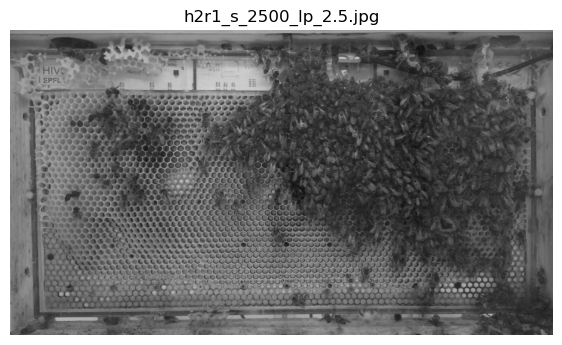

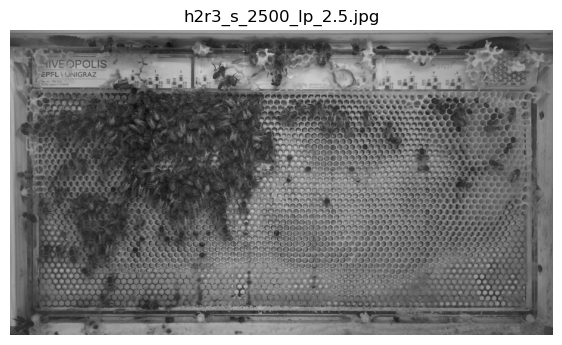

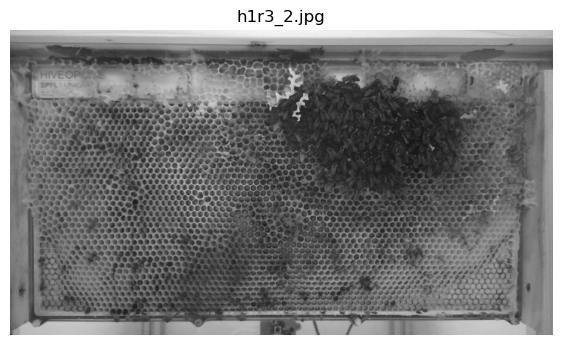

In [15]:
folder_in = 'clusters/'
folder_out = 'clusters_with_contours/'
images = glob.glob(folder_in + '*.jpg')
imgs = []

for image in images:
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    imgs.append(img)
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(img, cmap='gray')
    ax.title.set_text(image.replace(folder_in, ''))
    ax.axis('off')
    plt.show()

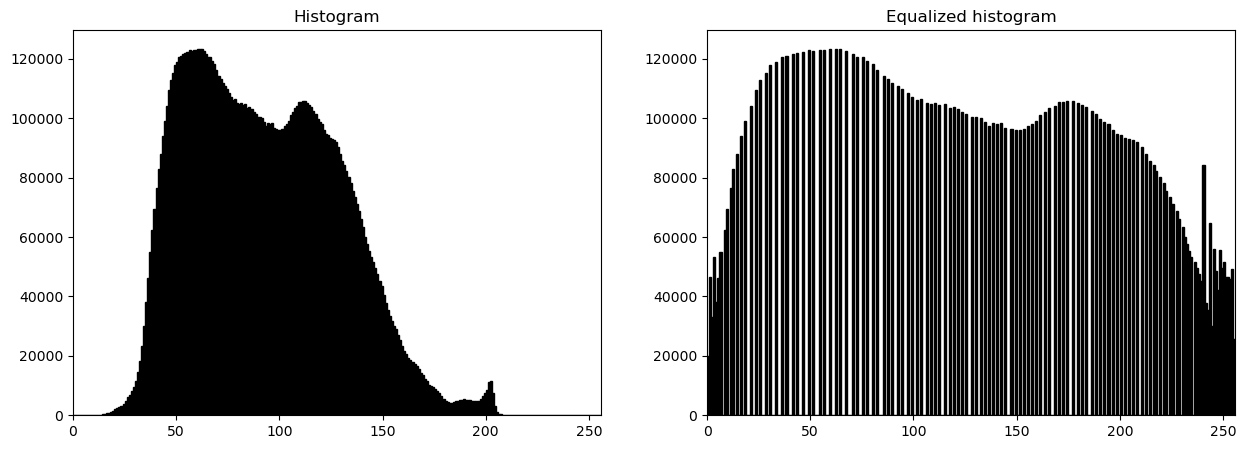

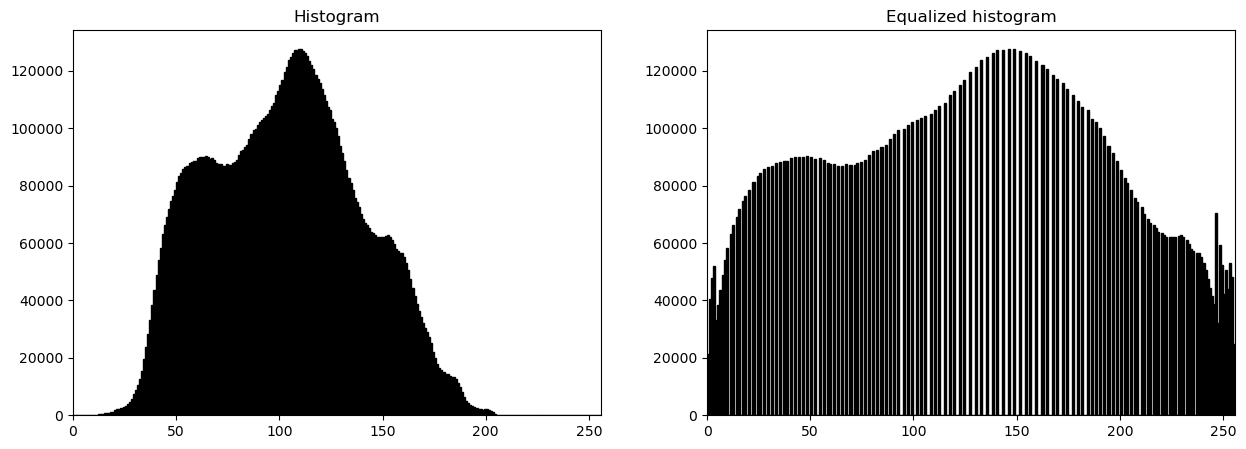

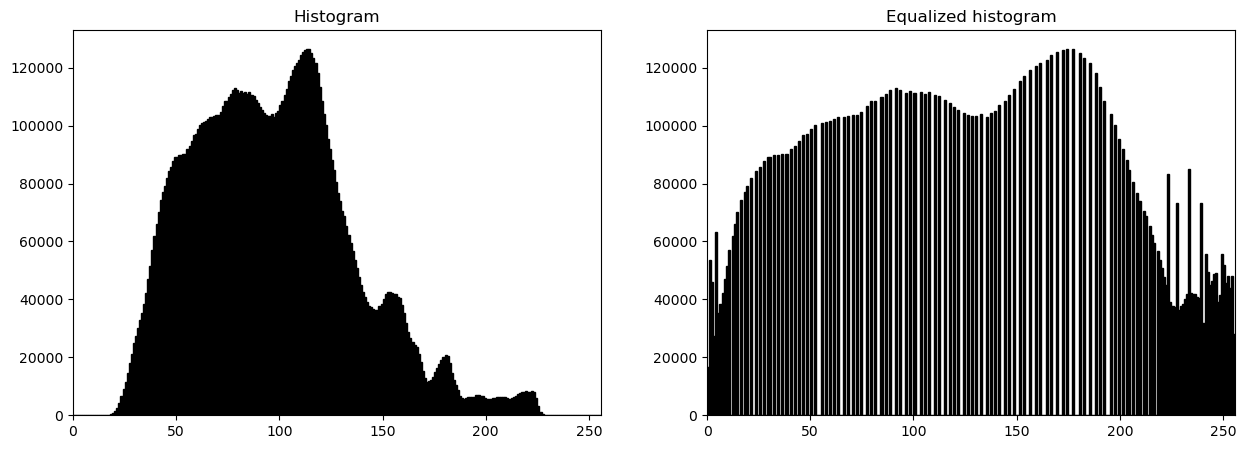

In [18]:
# plot histograms
for img in imgs:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].hist(img.ravel(), bins=256, range=(0, 256), fc='k', ec='k')
    ax[0].set_xlim([0, 256])
    ax[0].title.set_text('Histogram')
    img2 = cv2.equalizeHist(img)
    ax[1].hist(img2.ravel(), bins=256, range=(0, 256), fc='k', ec='k')
    ax[1].set_xlim([0, 256])
    ax[1].title.set_text('Equalized histogram')
    plt.show()

In [4]:
thresholds= [80, 80, 80]
imgs_tmp = []

for img, threshold in zip(imgs, thresholds):
    img_tmp = cv2.equalizeHist(img) #histogram equalization
    img_tmp = cv2.GaussianBlur(img, (7, 7), 0) #blur cause it never caused any harm
    _, img_tmp = cv2.threshold(img_tmp, threshold, 255, cv2.THRESH_BINARY) #thresholding
    imgs_tmp.append(img_tmp)

In [5]:
imgs_tmp1000_oc = []
n = 0
for img_tmp in imgs_tmp:
    # some morphological operations (this take lil bit of time)
    img_tmp1000 = remove_small_objects(img_tmp, min_size=1000) #remove small objects
    img_tmp1000 = remove_small_holes(img_tmp1000, area_threshold=1000) #remove small holes
    img_tmp1000_oc = closing(opening(img_tmp1000, disk(9)), disk(9)) #open then close the mask
    imgs_tmp1000_oc.append(img_tmp1000_oc)
    # to save time in the future, save the masks
    cv2.imwrite('mask'+str(n)+'.jpg', img_tmp1000_oc * 255)
    n += 1

/var/folders/81/88qz8hc518d6msz681nh39mm0000gn/T/ipykernel_26956/4073018611.py:6: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  img_tmp1000 = remove_small_holes(img_tmp1000, area_threshold=1000) #remove small holes


In [6]:
# we load mask that were preprocessed to save time on morphological operations if we dont want to redo them
imgs_tmp1000_oc = []

for n in range(3):
    img_tmp1000_oc = cv2.imread('mask'+str(n)+'.jpg', cv2.IMREAD_GRAYSCALE)
    imgs_tmp1000_oc.append(img_tmp1000_oc)


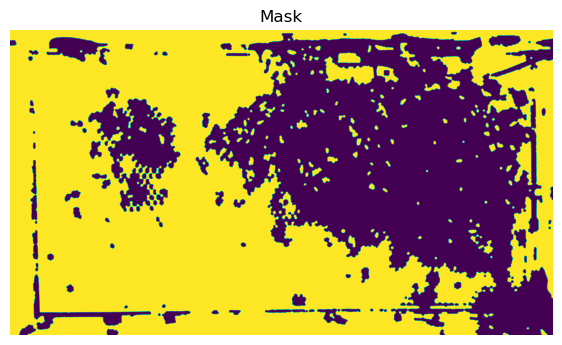

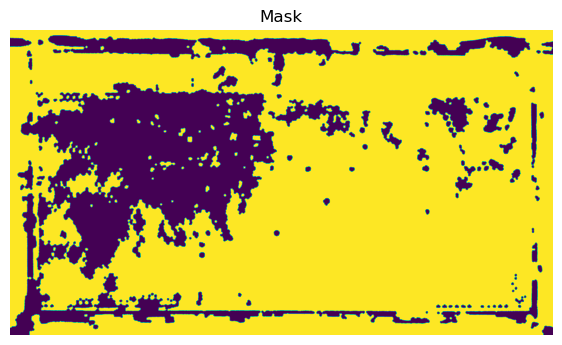

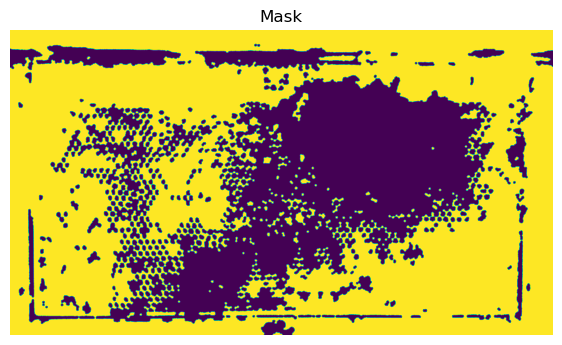

In [7]:
# show the masks
for img_tmp1000_oc in imgs_tmp1000_oc:
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(img_tmp1000_oc)
    ax.axis('off')
    ax.set_title('Mask')
    plt.show()

In [10]:
imgs_contour = []

# now we can find the contours
for img_tmp1000_oc, img in zip(imgs_tmp1000_oc, imgs):
    img_contour = (~img_tmp1000_oc).astype(np.uint8) #convert to uint8 because findContours only accepts uint8
    contours, _ = cv2.findContours(img_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
    contour = max(contours, key=cv2.contourArea) #get the biggest contour
    img_contour = cv2.cvtColor(img_contour, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
    cv2.drawContours(img, contour, -1, (255, 255, 255), 20) #draw the biggest contour
    print('Area of the biggest contour:', cv2.contourArea(contour), "pixels") #print the area of the biggest contour
    imgs_contour.append(img_contour)

Area of the biggest contour: 4573938.0 pixels
Area of the biggest contour: 2126399.5 pixels
Area of the biggest contour: 3518283.5 pixels


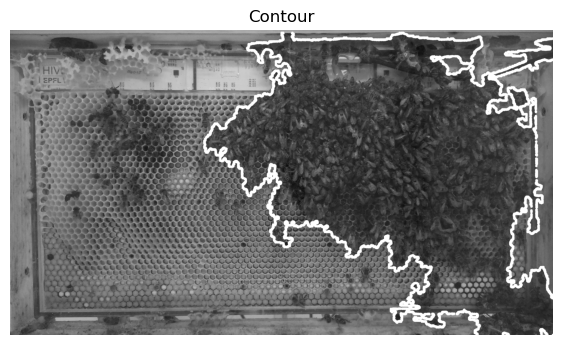

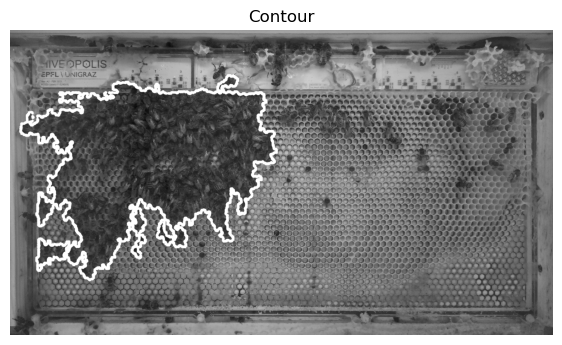

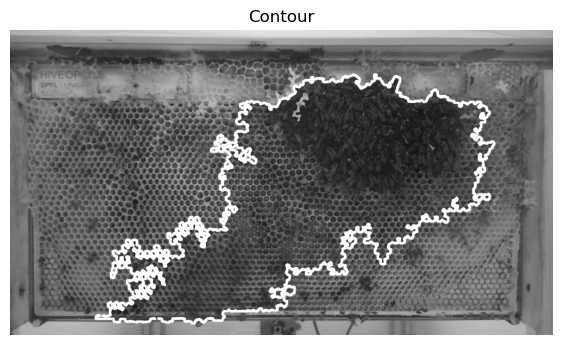

In [11]:
# show the contour
for img in imgs:
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title('Contour')
    plt.show()

In [12]:
# save the contours
n = 0
for img in imgs:
    cv2.imwrite(folder_out + 'contour' + str(n) + '.jpg', img)
    n += 1